In [8]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from mdn import MDN
from ud_sac import UDSAC, sample_episode
from core import Critic, ReplayBuffer
from torch.distributions import Normal

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class RandomAgent:
    def __init__(self, env, action_size):
        self.env = env
        self.action_size = action_size
        
    def __call__(self, state, command):
        actions = [self.env.action_space.sample() for _ in range(state.shape[0])]
        
        return torch.tensor(actions)

In [166]:
class MDNControllerV4:
    def __init__(self, state_size, action_size, command_size, mdn_heads, temperature, lr):
        self.model = MDN(state_size, command_size, n_heads=mdn_heads)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.temperature = temperature
        self.mdn_heads = mdn_heads
        
    def _loss(self, actor, critic, states):
        COMMAND_SAMPLE_SIZE = 1
        
        log_alpha, mu, sigma = self.model(state)
        dist = Normal(mu, sigma)
        
        commands = dist.sample(sample_shape=torch.tensor([COMMAND_SAMPLE_SIZE]))
        actions = F.one_hot(actor(states, commands), num_classes=self.action_size)
        
        # expectation over command samples for each head -> [batch_size, n_heads]
        controller_entropy = -self.temperature * dist.log_prob(commands).sum(-1).mean(0)
        
        # expectation over command samples for each head -> [batch_size, n_heads]
        critic_commands_logprob = critic.log_prob(
            states.unsqueeze(1).repeat(1, COMMAND_SAMPLE_SIZE * self.mdn_heads, 1).reshape(-1, self.state_size),
            commands.reshape(-1, 2),
            actions.unsqueeze(1).repeat(1, COMMAND_SAMPLE_SIZE * self.mdn_heads, 1).reshape(-1, self.action_size),
            commands.reshape(-1, 2)
        ).reshape(COMMAND_SAMPLE_SIZE, states.shape[0], self.mdn_heads).mean(0)
        
        loss = (log_alpha.exp() * (critic_commands_logprob + controller_entropy)).sum(dim=-1)
        
        return -loss.mean()
    
    def update(self, actor, critic, states):
        loss = self._loss(actor, critic, states)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
    
    def get_command(self, state):
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        
        log_alpha, mu, sigma = self.model(state)
        command = self.model.sample(log_alpha, mu, sigma).squeeze().cpu().numpy()

#         return command[0], command[1]
        return command[0], command[0]

In [167]:
# state[:2].unsqueeze(1).repeat(1, 10, 1).reshape(-1, 4)

In [168]:
def sample_random_batch(env_name, num_episodes=32, batch_size=64):    
    env = gym.make(env_name)
    buffer = ReplayBuffer()
    
    episodes = [sample_episode(env, None, None) for _ in range(num_episodes)]
    buffer.add_episodes(episodes)
    
    return buffer.sample(batch_size)

In [181]:
critic = Critic(4, 2, 2, n_heads=5)
critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-4)

actor = RandomAgent(gym.make("CartPole-v0"), 2)
controller = MDNControllerV4(4, 2, 2, 5, 0.2, 1e-4)

In [182]:
total_critic_loss = 0.0
total_controller_loss = 0.0

updates_per_iter = 10

for epoch in range(10_000):    
    state, command, action, reward, output = sample_random_batch("CartPole-v0")

    state = torch.tensor(state, dtype=torch.float32)
    command = torch.tensor(command, dtype=torch.float32)

    action = torch.tensor(action, dtype=torch.float32)
    action = F.one_hot(action.long(), num_classes=2)

    reward = torch.tensor(reward, dtype=torch.float32)
    output = torch.tensor(output, dtype=torch.float32)
    
    for _ in range(updates_per_iter):
        critic_loss = critic.nll_loss(state, command, action, output)

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

        total_critic_loss += critic_loss.item()
    
#     for _ in range(updates_per_iter):
        controller_loss = controller.update(actor, critic, state)
        total_controller_loss += controller_loss.item()
    
    
    if epoch % 100 == 0:
        total_updates = (epoch + 1) * updates_per_iter
        
        print(total_critic_loss / total_updates, total_controller_loss / total_updates)

163.81884002685547 2.3091763257980347
30.270786351496632 2.8342899853640264
19.114293207102154 3.3447400243721197
15.135287720182806 3.76412468091198
13.06252026653052 4.190411410783592
11.791032902304522 4.6494807278086805
10.94252128958107 5.14083905001845
10.310503320993268 5.644520174487681
9.829821167099341 6.054686082614942
9.414284004567069 6.383224388682485
9.070547836858195 6.705850464695103
8.779432428890093 7.079899602213521
8.529686228143087 7.558859552948005
8.298251595559439 8.229629019551053
8.095798140198397 9.044034484196866
7.926667809581693 9.68459700154591
7.775013507760219 10.260989338677053
7.637132891159349 10.987841572570913
7.516547271253532 11.641497063954494
7.4007760291347875 12.314287867250096
7.29331138863199 12.775845229405276
7.195881588137871 13.110487139094506
7.105451479666561 13.471160243815154
7.024495954256584 13.811060907124748
6.946687936832487 14.177613335984391
6.875463227956879 14.607852163328165
6.8070382417325375 14.926478693339513
6.7419966

KeyboardInterrupt: 

In [ ]:
# for epoch in range(5000):    
#     controller_loss = controller.update(actor, critic, state)
    
#     if epoch % 100 == 0:
#         print(controller_loss.item())

In [183]:
test_episode = sample_episode(gym.make("CartPole-v0"), None, None)

test_init_state = torch.tensor(test_episode.states[0]).unsqueeze(0).float()
test_init_command = torch.tensor(test_episode.commands[0]).unsqueeze(0).float()
test_init_action = F.one_hot(torch.tensor(test_episode.actions[0]), num_classes=2).unsqueeze(0).float()

tensor([20.9308, 20.9512])


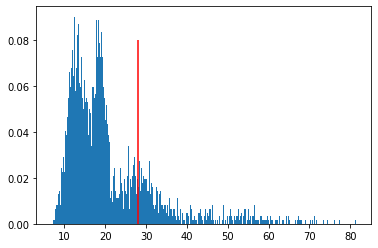

In [184]:
sample = [critic.sample(test_init_state, test_init_command, test_init_action) for _ in range(5000)]

print(torch.cat(sample).mean(dim=0))

plt.hist(torch.cat(sample)[:, 0].numpy(), bins=600, density=True);
plt.vlines(test_episode.total_return, 0, 0.08, colors="red");

In [187]:
controller_sample = [controller.get_command(test_episode.states[0])[0] for _ in range(5000)]

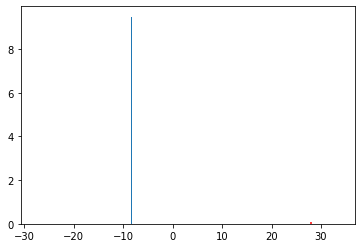

In [189]:
plt.hist(controller_sample, bins=600, density=True);
plt.vlines(test_episode.total_return, 0, 0.1, colors="red");

In [190]:
controller_sample

[-8.326741,
 -8.317663,
 -8.319872,
 -8.323889,
 -8.313568,
 -8.341432,
 -8.323226,
 -8.341427,
 -8.318531,
 -8.308359,
 -8.306622,
 -8.338372,
 -8.348405,
 -8.317307,
 6.4391747,
 -8.347205,
 -8.342011,
 -8.337263,
 -8.333707,
 -8.331037,
 -8.320717,
 -8.318426,
 -8.339238,
 -8.3461,
 -8.299755,
 -8.316079,
 -8.320557,
 -8.311147,
 -8.3398285,
 -8.333545,
 -8.321353,
 -8.331364,
 -8.333023,
 -8.335043,
 -8.322791,
 -8.335984,
 -8.330723,
 -8.343683,
 -8.316103,
 -8.310783,
 -8.306248,
 -8.3141985,
 -8.337638,
 -8.339687,
 -8.356657,
 -8.323696,
 -8.335648,
 -8.345199,
 -8.341913,
 -8.353262,
 -8.324209,
 -8.307403,
 -8.304752,
 -8.310398,
 -8.325881,
 -8.328059,
 -8.340879,
 -8.34577,
 -8.316995,
 -8.324612,
 -8.33726,
 -8.322198,
 -8.320088,
 -8.317632,
 -8.317307,
 -8.320398,
 -8.32704,
 -8.307992,
 -8.321333,
 -8.310833,
 -8.334545,
 -8.289182,
 -8.326715,
 -8.331489,
 -8.326384,
 -8.332724,
 -8.307366,
 -8.328062,
 -8.324065,
 -8.352921,
 -8.326282,
 -8.319005,
 -8.312547,
 -8.323